# Mid-Term 1


In [2]:
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
def load_dataset(name):
    X, y = [], []
    with open("{}".format(name), 'r') as f:
        for line in f.readlines():
            splitted = line.split(",")
            X.append(splitted[:-1])
            y.append(splitted[-1])
    X, y = np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)
    return X, y

### Prelude

Load the following 7 datasets:

- dataset 1: (X1, y1) with $X1 \in \mathbb{R}^{ 50 \times 10}$ and noise variance $\sigma = 0.1$
- dataset 2: (X2, y2) with $X2 \in \mathbb{R}^{ 500 \times 10}$ and noise variance $\sigma = 0.1$
- dataset 3: (X3, y3) with $X3 \in \mathbb{R}^{ 1000 \times 10}$ and noise variance $\sigma = 0.1$
- dataset 4: (X4, y4) with $X4 \in \mathbb{R}^{ 500 \times 500}$ and noise variance $\sigma = 0.1$
- dataset 5: (X5, y5) with $X5 \in \mathbb{R}^{ 500 \times 5000}$ and noise variance $\sigma = 0.1$
- dataset 6: (X6, y6) with $X6 \in \mathbb{R}^{ 500 \times 10000}$ and noise variance $\sigma = 0.1$
- dataset 7: (X7, y7) with $X7 \in \mathbb{R}^{ 500 \times 1}$ and noise variance $\sigma = 0.3$

i.e. datasets from 1 to 3 have fixed input space dimension $d = 10$ and different number of points, while datasets from 4 to 6 have fixed number of points and different number of dimensions.

In [4]:
# Load dataset 1
(Xtr_1, ytr_1), (Xte_1, yte_1) = load_dataset(
    "./datasets/dataset_1_train"), load_dataset("./datasets/dataset_1_test")

# Load dataset 2
(Xtr_2, ytr_2), (Xte_2, yte_2) = load_dataset(
    "./datasets/dataset_2_train"), load_dataset("./datasets/dataset_2_test")

# Load dataset 3
(Xtr_3, ytr_3), (Xte_3, yte_3) = load_dataset(
    "./datasets/dataset_3_train"), load_dataset("./datasets/dataset_3_test")

# Load dataset 4
(Xtr_4, ytr_4), (Xte_4, yte_4) = load_dataset(
    "./datasets/dataset_4_train"), load_dataset("./datasets/dataset_4_test")

# Load dataset 5
(Xtr_5, ytr_5), (Xte_5, yte_5) = load_dataset(
    "./datasets/dataset_5_train"), load_dataset("./datasets/dataset_5_test")

# Load datset 6
(Xtr_6, ytr_6), (Xte_6, yte_6) = load_dataset(
    "./datasets/dataset_6_train"), load_dataset("./datasets/dataset_6_test")

# Load datset 7
Xtr_7, ytr_7 = load_dataset("./datasets/dataset_7_train")

# SUGGESTION!!! Check the size of each dataset

# Example
print(np.shape(Xtr_7))

(400, 1)


Tips and tricks:
- to estimate the computational time of a certain portion of code use the following
    
    `
    t0 = time.time()
    ... my code ...
    mycode_time = time.time()-t0`

In [5]:
# Example

t0 = time.time()
_ = load_dataset("./datasets/dataset_3_train")
DeltaT = time.time() - t0

print("[--] Dataset 3 loaded in {} seconds".format(DeltaT))

[--] Dataset 3 loaded in 0.0030028820037841797 seconds


### Activity 1 

Compare the behavior of K-NN and RLS on the datasets according to the following tasks:
- Task 1.1: Compare training, validation, test errors and training and test time of the two methods on datasets 1, 2, 3
- Task 1.2: Compare training, validation, test errors and training and test time of the two methods on datasets 4, 5, 6 




In [6]:
# Utils
def euclidDistance(P1, P2):
    return np.linalg.norm(P1-P2, 2)


def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1, idx2] = euclidDistance(X1[idx1, :], X2[idx2, :])
    return D


def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy


def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)


def plot_knn_errors(k_list, best_k, val_mean, val_var, tr_mean, tr_var, dataset_n):
    _, ax = plt.subplots()
    ax.set_title(f"KNN error (Dataset {dataset_n})")
    ax.errorbar(k_list, val_mean, val_var, label="Validation error")
    ax.errorbar(k_list, tr_mean, tr_var, label="Training error")
    ax.axvline(best_k, linestyle="--", c="black", alpha=0.7,
               label=f"best K ({best_k})")
    # Only show integer labels on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(loc="best")
    ax.set_ylabel("Error")
    ax.set_xlabel("K")


def plot_rls_errors(lam_list, bestlam, Vm, Tm, dataset_n):
    _, ax = plt.subplots()
    ax.set_title(f"RLS error (Dataset {dataset_n})")
    ax.plot(lam_list, Vm, '-o', label="Validation error")
    ax.plot(lam_list, Tm, '-o', label="Train error")
    ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7,
               label=f"best $\lambda$ ({bestlam:.2e})")
    ax.set_xscale("log")
    ax.set_xlabel("$\lambda$")
    ax.set_ylabel("MSE")
    ax.legend(loc="best")

<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
/var/folders/q5/2vqyn_hx6v7gdx1c0f59g4300000gn/T/ipykernel_1730/1196811722.py:60: SyntaxWarning: invalid escape sequence '\l'
  label=f"best $\lambda$ ({bestlam:.2e})")
/var/folders/q5/2vqyn_hx6v7gdx1c0f59g4300000gn/T/ipykernel_1730/1196811722.py:62: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$")


In [7]:
# CV for KNN (regression)

def kNNRegression(Xtr, Ytr, k, Xte):
    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if k > n_train:
        k = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = avg_neigh

    return Ypred


def KFoldCVkNN(Xtr, Ytr, KF, k_list):
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = k_list.size

    n_tot = Xtr.shape[0]
    # Number of values in the interval of the validation set
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, KF))
    val_errors = np.zeros((num_k, KF))

    for kdx, k in enumerate(k_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        # We generate a random vector of n_tot elements with no repetitions
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        # Then we split it into KF subarrays
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            # We generate a boolean array of n_tot elements all to False
            val_mask = np.zeros(n_tot, dtype=bool)
            # Then we get the validation set by setting to True the starting index of the current fold
            val_mask[split_idx[fold]] = True

            # NOTE: with this notation Xtr[~val_mask] we are taking all those elements
            # of which val_mask = False (like Xtr[val_mask == False])
            # The training set are the one that are val_mask = False
            X = Xtr[~val_mask]
            Y = Ytr[~val_mask]
            # The validation set is the one with val_mask = True
            X_val = Xtr[val_mask]
            Y_val = Ytr[val_mask]

            # Compute the training error of the kNN classifier for the given value of k
            tr_errors[kdx, fold] = calcError(kNNRegression(X, Y, k, X), Y)

            # Compute the validation error of the kNN classifier for the given value of k
            val_errors[kdx, fold] = calcError(
                kNNRegression(X, Y, k, X_val), Y_val)

    # Calculate error statistics along the repetitions
    # NOTE: axis=1 means we are taking the mean/variance the rows
    # np.mean([[1, 2], [3, 4]], axis=1) = 2+1/2, 3+4/2
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    # The best k is the one that minimizes the validation error expectation
    best_k_idx = np.argmin(val_mean)
    best_k = k_list[best_k_idx]

    return best_k, val_mean, val_var, tr_mean, tr_var

### regularizedLSTrain

if $n > d \implies w_{\lambda} = (X^TX + \lambda n I)^{-1}\ X^TY$

if $n \le d \implies$

$$
c = (XX^T + \lambda n I)^{-1}\ Y
$$

$$w_{\lambda} = X^Tc$$

In [8]:
# CV for RLS (regression)

def regularizedLSTrain(Xtr, Ytr, lam):
    n = Xtr.shape[0]
    d = Xtr.shape[1]

    if n > d:
        XTY = Xtr.T @ Ytr
        XTX = Xtr.T @ Xtr
        return np.linalg.inv(XTX + lam * n * np.identity(d)) @ XTY
    # else n <= d
    XXT = Xtr @ Xtr.T
    c = np.linalg.inv(XXT + lam * n * np.identity(n)) @ Ytr
    return Xtr.T @ c


def regularizedLSTest(w, Xte):
    return np.dot(Xte, w)


def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for idx, regpar in enumerate(regpar_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[~val_mask]  # training input
            Y = Ytr[~val_mask]  # training output
            X_val = Xtr[val_mask]  # validation input
            Y_val = Ytr[val_mask]  # validation output

            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)

            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)

    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

# Task 1.1

**Tips**: to compare the methods, you should

- plot training and validation errors for the different hypeparameter values considered in the cross-validation procedure
- print in output the training, validation and test errors corresponding to the final model

In [9]:
knn_times = []
rls_times = []

### Dataset 1

<>:73: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\l'
/var/folders/q5/2vqyn_hx6v7gdx1c0f59g4300000gn/T/ipykernel_1730/3082609034.py:73: SyntaxWarning: invalid escape sequence '\l'
  label=f"best $\lambda$ ({bestlam:.2e})")


Dataset 1:
	KNN
[--] Training time: 0.009206056594848633 s
[--] Training error: 0.5867178441367273
[--] Test time: 0.0027680397033691406 s
[--] Test error: 0.47875564129291276
[--] Validation error: 0.7664642752901607
	RLS
[--] Training time 0.00010180473327636719 s
[--] Training error 0.00920993546235519
[--] Test time 1.0967254638671875e-05 s
[--] Test error 0.020642603813426325
[--] Validation error: 0.015782816506795767




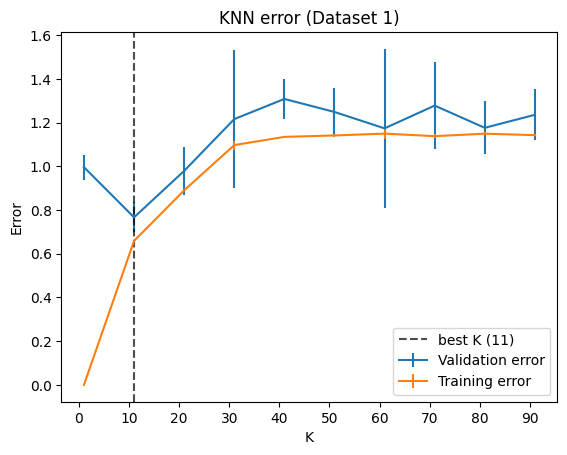

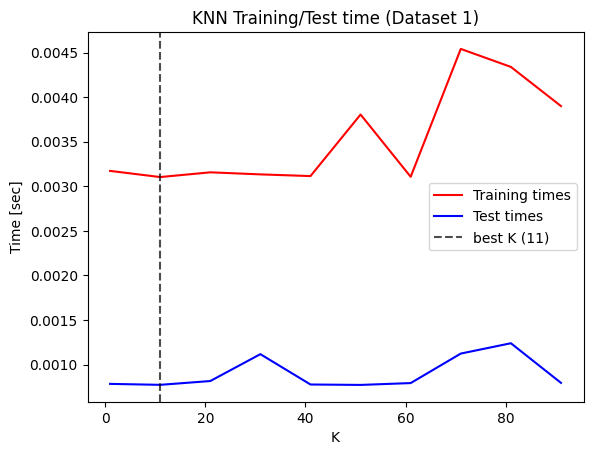

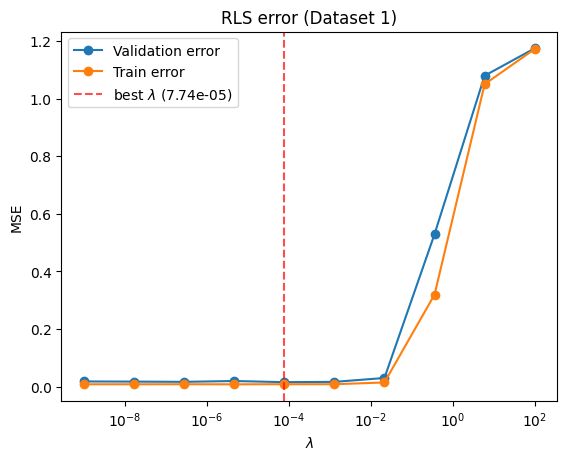

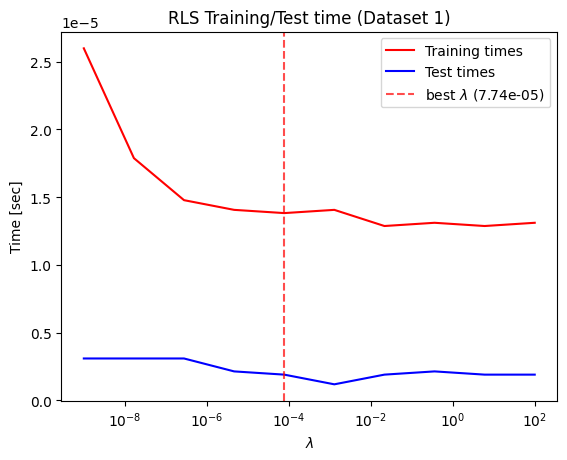

In [10]:
def analyze_dataset(Xtr, Ytr, Xte, Yte, i):
    """
    Apply K-NN and RLS, then measures the elapsed time and the errors for both 
    the algorithms
    """
    global knn_times, rls_times

    Ks = list(range(1, 100, 10))
    lams = np.logspace(-9, 2, 10)
    KF = 5

    # cross validation of KNN for dataset i
    best_k, val_mean_knn, val_var, tr_mean, tr_var = KFoldCVkNN(
        Xtr, Ytr, KF, Ks)
    plot_knn_errors(Ks, best_k, val_mean_knn, val_var, tr_mean, tr_var, i)

    # time estimation
    tr_times = []  # Computational training times
    te_times = []  # Computational test times
    for k in Ks:
        t0 = time.time()
        y_pred_tr = kNNRegression(Xtr, Ytr, k, Xtr)
        DeltaT_tr = time.time() - t0
        t0 = time.time()
        y_pred_te = kNNRegression(Xtr, Ytr, k, Xte)
        DeltaT_te = time.time() - t0

        if best_k == k:  # we have taken the time with respect to the bestlam
            knn_times.append(DeltaT_tr)

        tr_times.append(DeltaT_tr)
        te_times.append(DeltaT_te)

    _, ax = plt.subplots()
    ax.set_title(f"KNN Training/Test time (Dataset {i})")
    ax.plot(Ks, tr_times, c="red", label="Training times")
    ax.plot(Ks, te_times, c="blue", label="Test times")
    ax.axvline(best_k, linestyle="--", c="black", alpha=0.7,
               label=f"best K ({best_k})")
    ax.set_xlabel("K")
    ax.set_ylabel("Time [sec]")
    ax.legend()

    # cross validation of RLS for dataset i
    bestlam, val_mean_rls, val_var, tr_mean, tr_var = KFoldCVRLS(
        Xtr, Ytr, KF, lams)
    plot_rls_errors(lams, bestlam, val_mean_rls, tr_mean, i)

    # time estimation
    tr_times = []  # Computational training times
    te_times = []  # Computational test times
    for lam in lams:

        t0 = time.time()
        w = regularizedLSTrain(Xtr, Ytr, lam)
        DeltaT_tr = time.time() - t0
        t0 = time.time()
        y_pred_tr = regularizedLSTest(w, Xtr)  # w^T X
        y_pred_te = regularizedLSTest(w, Xte)
        DeltaT_te = time.time() - t0

        if lam == bestlam:  # we have taken the time with respect to the bestlam
            rls_times.append(DeltaT_tr)

        tr_times.append(DeltaT_tr)
        te_times.append(DeltaT_te)

    _, ax = plt.subplots()
    ax.set_title(f"RLS Training/Test time (Dataset {i})")
    ax.plot(lams, tr_times, c="red", label="Training times")
    ax.plot(lams, te_times, c="blue", label="Test times")
    ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7,
               label=f"best $\lambda$ ({bestlam:.2e})")
    ax.set_xlabel(r"$\lambda$")
    ax.set_xscale("log")
    ax.set_ylabel("Time [sec]")
    ax.legend()

    # train KNN with parameter obtained by KFold-Cross Validation and estimate computational time
    t0 = time.time()
    y_pred_tr = kNNRegression(Xtr, Ytr, best_k, Xtr)
    DeltaT_tr = time.time() - t0
    t0 = time.time()
    y_pred_te = kNNRegression(Xtr, Ytr, best_k, Xte)
    DeltaT_te = time.time() - t0

    print(f"Dataset {i}:")
    print("\tKNN")
    print("[--] Training time:", DeltaT_tr, "s")
    print("[--] Training error:", calcError(y_pred_tr, Ytr))
    print("[--] Test time:", DeltaT_te, "s")
    print("[--] Test error:", calcError(y_pred_te, Yte))
    print("[--] Validation error:", val_mean_knn[best_k // 10])

    # train RLS with parameter obtained by KFold-Cross Validation and estimate computational time
    t0 = time.time()
    w = regularizedLSTrain(Xtr, Ytr, bestlam)
    DeltaT_tr = time.time() - t0
    t0 = time.time()
    y_pred_tr = regularizedLSTest(w, Xtr)  # w^T X
    y_pred_te = regularizedLSTest(w, Xte)
    DeltaT_te = time.time() - t0

    print("\tRLS")
    print("[--] Training time", DeltaT_tr, "s")
    print("[--] Training error", calcError(y_pred_tr, Ytr))
    print("[--] Test time", DeltaT_te, "s")
    print("[--] Test error", calcError(y_pred_te, Yte))
    bestlam_idx = np.argmin(val_mean_rls)
    print("[--] Validation error:", val_mean_rls[bestlam_idx])
    print("\n")


analyze_dataset(Xtr_1, ytr_1, Xte_1, yte_1, 1)

### Dataset 2

Dataset 2:
	KNN
[--] Training time: 0.3799619674682617 s
[--] Training error: 0.21508438776540637
[--] Test time: 0.06978487968444824 s
[--] Test error: 0.18747983784491468
[--] Validation error: 0.3122608454382904
	RLS
[--] Training time 9.512901306152344e-05 s
[--] Training error 0.00985041188864479
[--] Test time 5.3882598876953125e-05 s
[--] Test error 0.009842346401150878
[--] Validation error: 0.0102305694981128




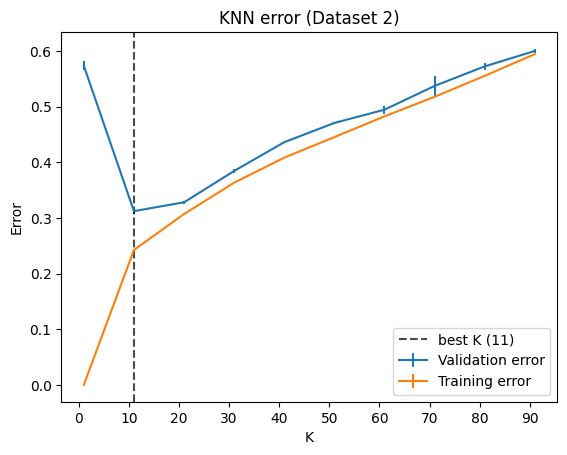

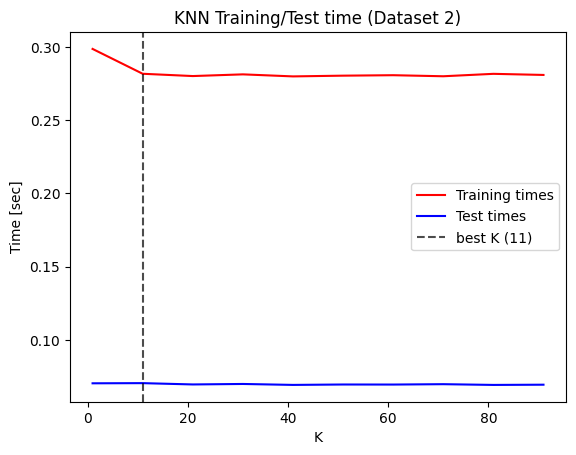

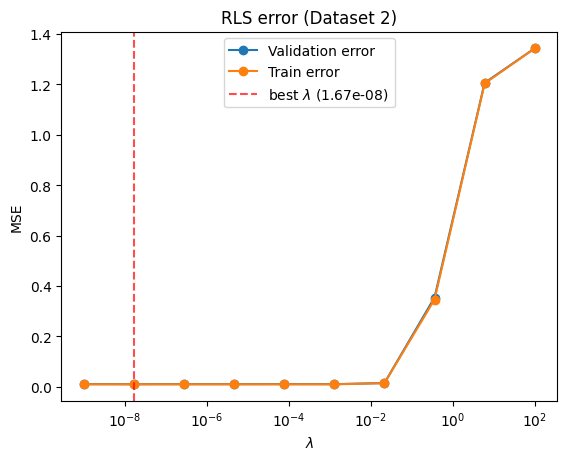

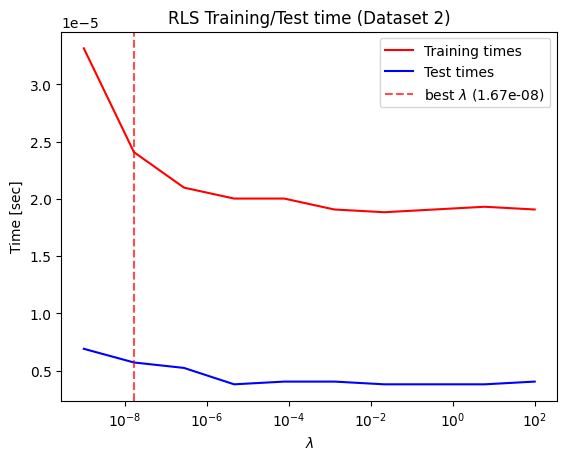

In [11]:
analyze_dataset(Xtr_2, ytr_2, Xte_2, yte_2, 2)

### Dataset 3

Dataset 3:
	KNN
[--] Training time: 1.2503111362457275 s
[--] Training error: 0.17270680939455182
[--] Test time: 0.286085844039917 s
[--] Test error: 0.2127557443601381
[--] Validation error: 0.22855833545822485
	RLS
[--] Training time 0.00622105598449707 s
[--] Training error 0.009397417778314706
[--] Test time 0.0008890628814697266 s
[--] Test error 0.010530223253806774
[--] Validation error: 0.009613442011655867




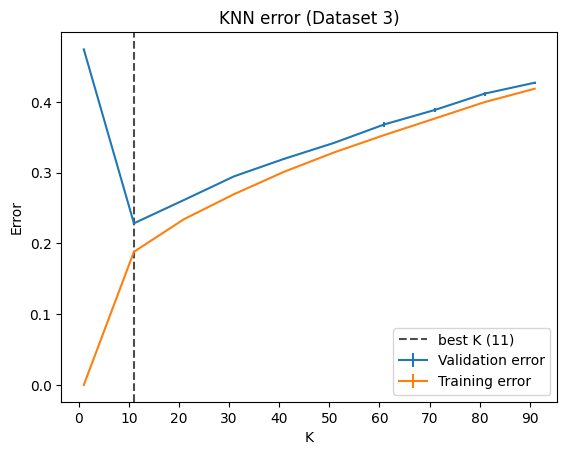

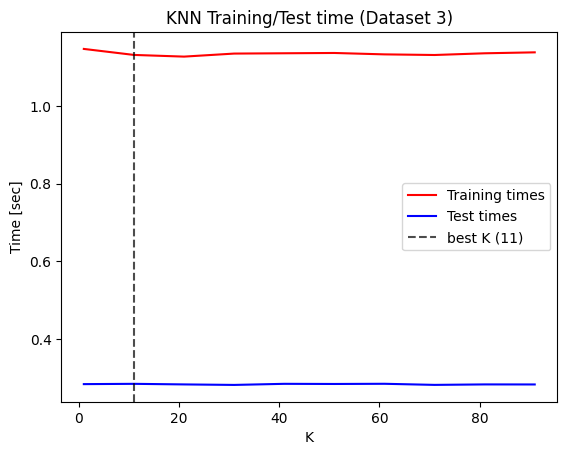

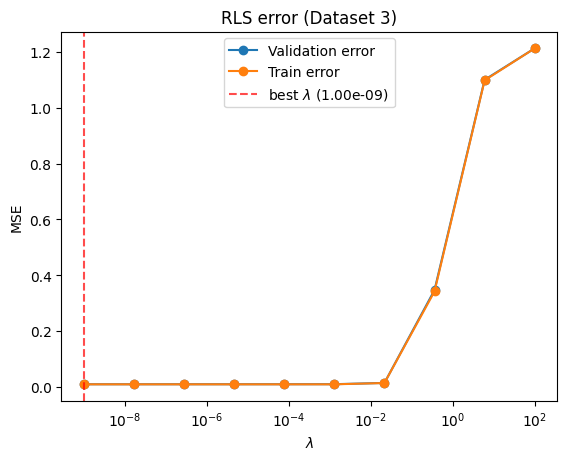

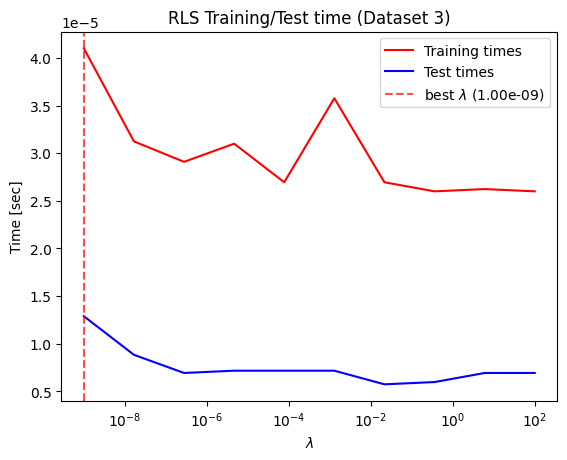

In [12]:
analyze_dataset(Xtr_3, ytr_3, Xte_3, yte_3, 3)

## Task 1.2

### Dataset 4

Dataset 4:
	KNN
[--] Training time: 0.41741299629211426 s
[--] Training error: 52.92230913710432
[--] Test time: 0.07617402076721191 s
[--] Test error: 47.723560315247205
[--] Validation error: 57.86852855678843
	RLS
[--] Training time 0.005406856536865234 s
[--] Training error 2.0064219819747327e-11
[--] Test time 0.0001518726348876953 s
[--] Test error 13.595888430251756
[--] Validation error: 18.227335705446215




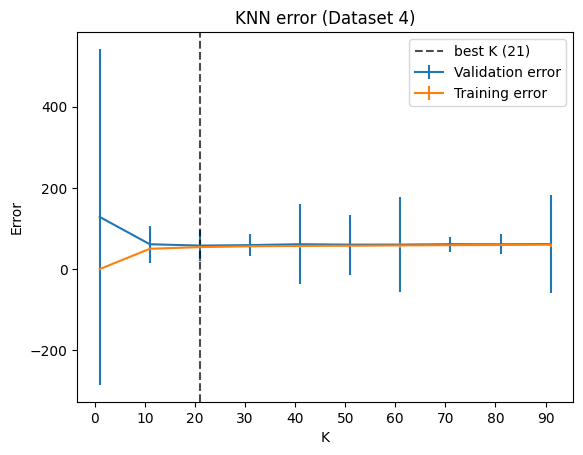

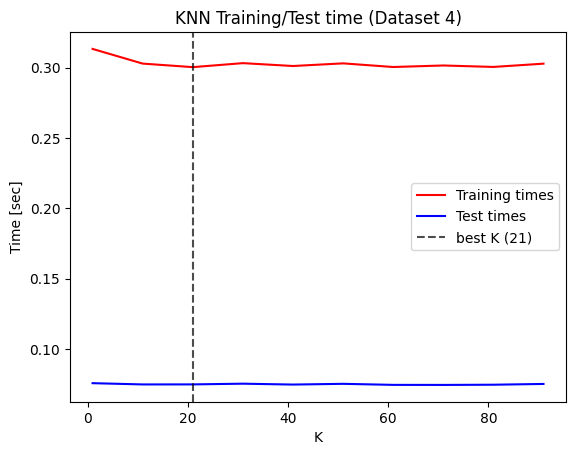

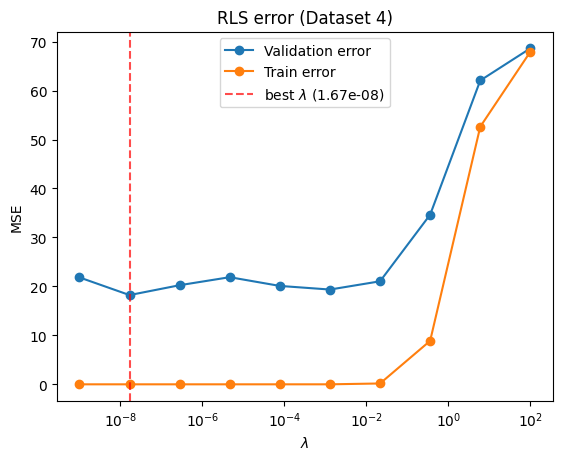

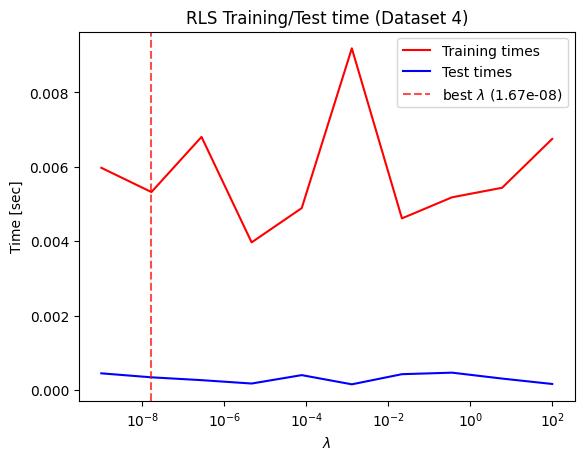

In [13]:
analyze_dataset(Xtr_4, ytr_4, Xte_4, yte_4, 4)

### Dataset 5

Dataset 5:
	KNN
[--] Training time: 0.5480718612670898 s
[--] Training error: 543.5805305990361
[--] Test time: 0.10963916778564453 s
[--] Test error: 509.4036481512669
[--] Validation error: 554.7124059473596
	RLS
[--] Training time 0.010639190673828125 s
[--] Training error 0.015704395999736373
[--] Test time 0.0024979114532470703 s
[--] Test error 487.53435311374494
[--] Validation error: 506.0377286196739




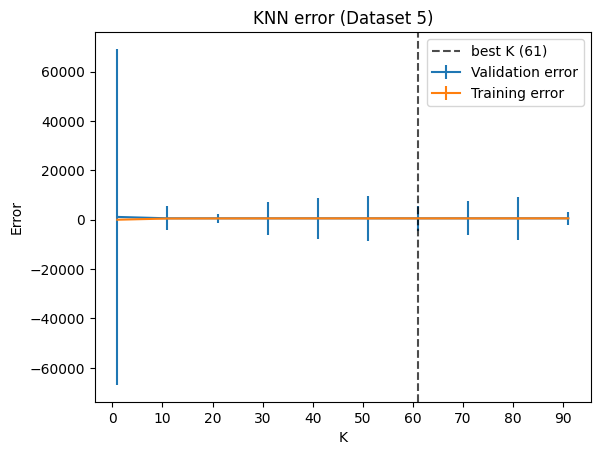

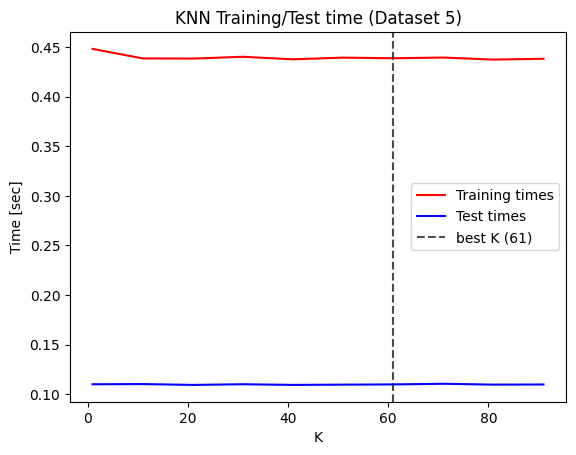

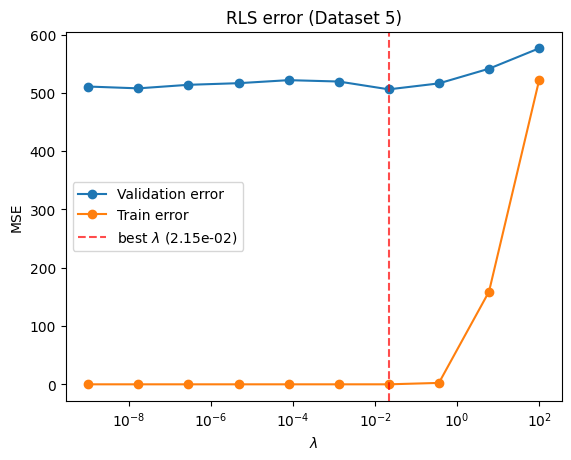

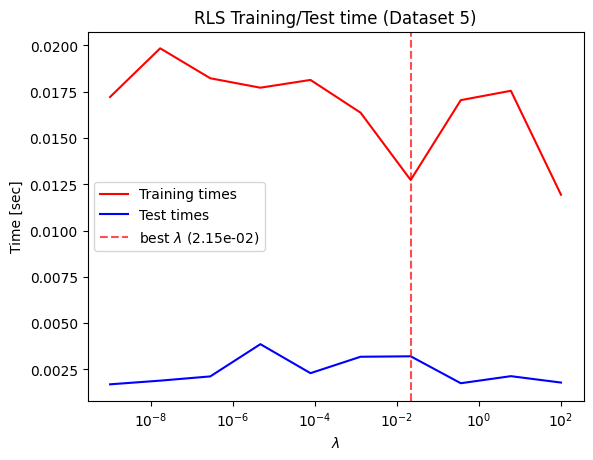

In [14]:
analyze_dataset(Xtr_5, ytr_5, Xte_5, yte_5, 5)

### Dataset 6

Dataset 6:
	KNN
[--] Training time: 0.7521750926971436 s
[--] Training error: 972.40797285094
[--] Test time: 0.16578388214111328 s
[--] Test error: 1053.332630606589
[--] Validation error: 1004.4374908399707
	RLS
[--] Training time 0.023396968841552734 s
[--] Training error 1.811050106259414
[--] Test time 0.006754875183105469 s
[--] Test error 977.3606044723291
[--] Validation error: 964.7094062706967




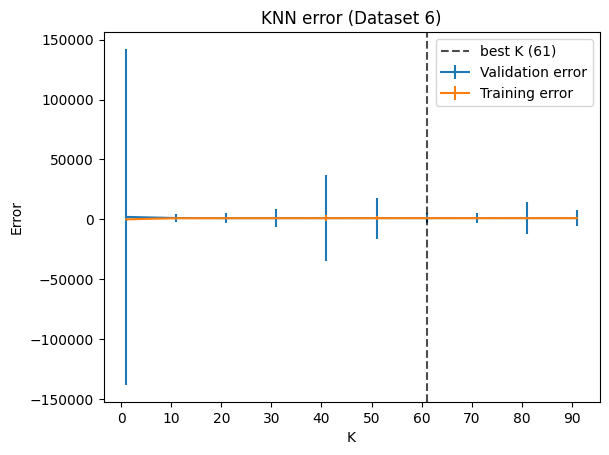

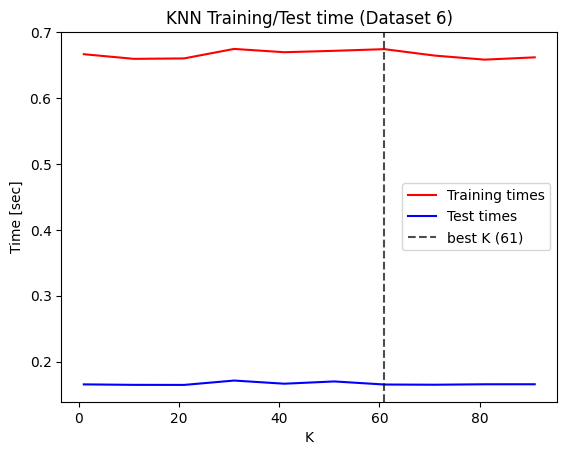

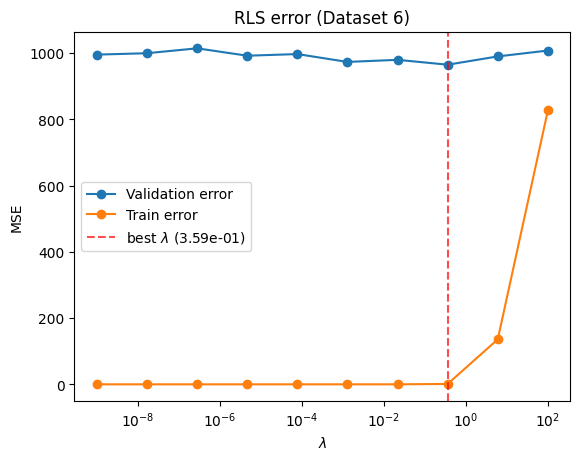

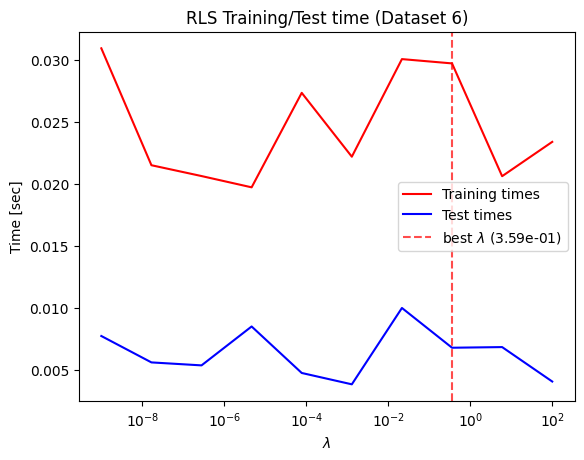

In [15]:
analyze_dataset(Xtr_6, ytr_6, Xte_6, yte_6, 6)

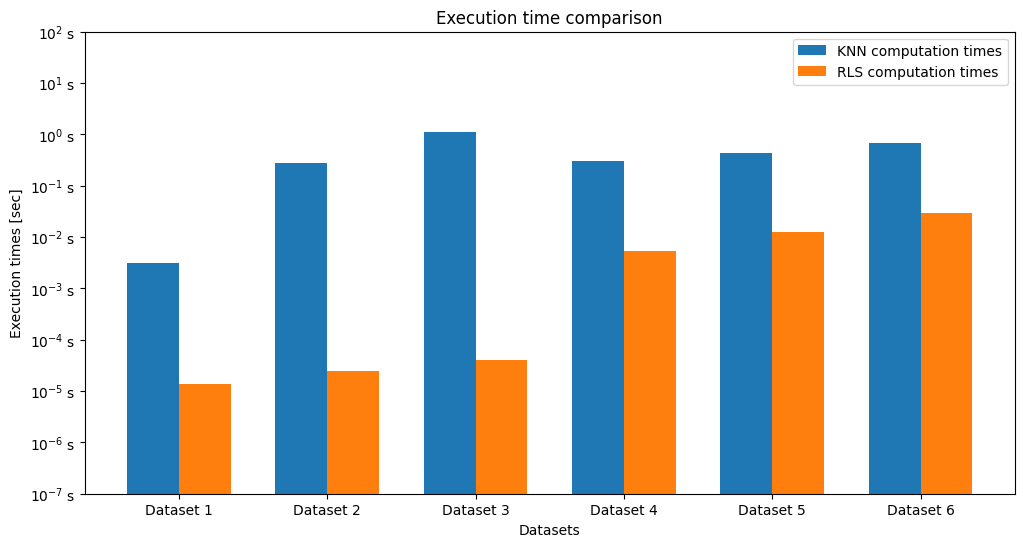

In [16]:
# TODO: we could do the same thing with the errors!

datasets = [i for i in range(1, 7)]
bar_width = 0.35  # bin width

# to put 2 bars on the same number, we set the position for knn to the
# number and rls right after
# we subtract and add a small portion to the positions so they are centered
knn_positions = [i - bar_width/2 for i in datasets]
# on the number on the x axis
rls_positions = [i + bar_width/2 for i in datasets]

plt.figure(figsize=(12, 6))
plt.bar(knn_positions, knn_times, width=bar_width,
        label="KNN computation times")
plt.bar(rls_positions, rls_times, width=bar_width,
        label="RLS computation times")

# Set the x ticks to be "dataset i" (e.g dataset 1)
xlabels = [f"Dataset {i}" for i in datasets]
plt.xticks(datasets, xlabels)

# set the y ticks to be "i s" (e.g. 0.6)
plt.yscale("log")
ylocs, ylabels = plt.yticks()
ylabels = [f"{i.get_text()} s" for i in ylabels]
plt.yticks(ylocs, ylabels)

plt.title("Execution time comparison")
plt.xlabel("Datasets")
plt.ylabel("Execution times [sec]")
plt.legend()

What can you observe? **Describe here your observations:**

### KNN

In the plots is possible to see that for k small we have a low training error and high validation error, this is due to the fact that for small k we check less neighbours, so we could compute a wrong prediction, propagating the noise (**underfitting**)

We also notice that for KNN, the best K always minimizes the validation error, as the plots show

finally, we can observe that for a higher number of samples $n$, KNN tends to be slower with respect to the number of dimensions $d$

### RLS

For the RLS model, we can observe that for small value of lambda we have a low error. As lambda grows, the error increses as well. 
So, for lambda growing, we have a better generalization, but if too large the accuracy of the model decreases (**overfitting**)

### Conclusions

From the data obtained with the datasets it is visible that the KNN model is not well scalable, as it takes up a lot of memory and is slower than the RLS model, this is visible from both the training time and the test time.

### Acitivity 2

Find your optimal solution for the dataset 7, we will evaluate the goodness of your model on the test set

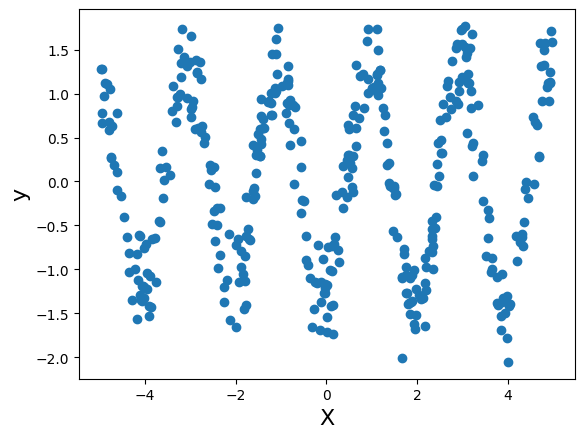

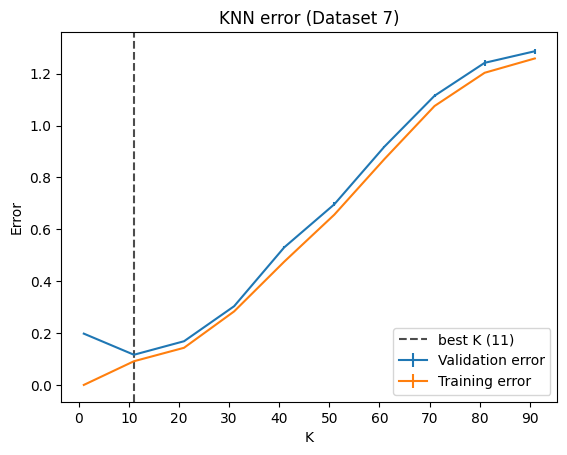

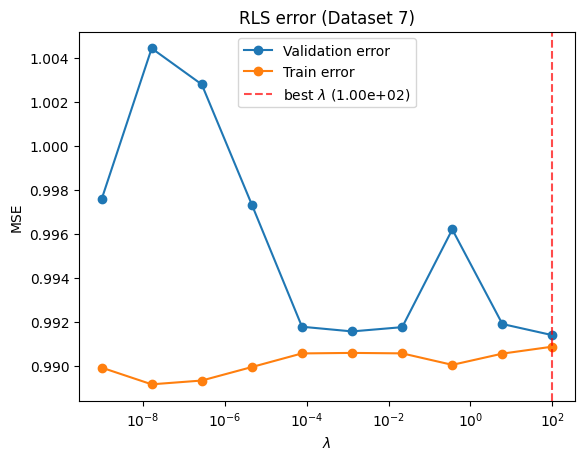

In [17]:
fig, ax = plt.subplots()
ax.plot(Xtr_7, ytr_7, 'o')
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("y", fontsize=16)

Ks = list(range(1, 100, 10))
lams = np.logspace(-9, 2, 10)
KF = 5

# cross validation of KNN for dataset 7
best_k, val_mean_knn, val_var, tr_mean, tr_var = KFoldCVkNN(
    Xtr_7, ytr_7, KF, Ks)
plot_knn_errors(Ks, best_k, val_mean_knn, val_var, tr_mean, tr_var, 7)

bestlam, val_mean_rls, val_var, tr_mean, tr_var = KFoldCVRLS(
        Xtr_7, ytr_7, KF, lams)
plot_rls_errors(lams, bestlam, val_mean_rls, tr_mean, 7)


As the plots above show, we notice that KNN has a lower validation error with respect to RLS.

RLS is a global method, so a small variation affects all the future predictions.

KNN is local, so with this dataset is better, because the data are not "linear".

In [18]:
Xte_7, yte_7 = load_dataset(...) # Add your test sets here

# KNN
y_pred_tr = kNNRegression(Xtr_7, ytr_7, best_k, Xtr_7)
y_pred_te = kNNRegression(Xtr_7, ytr_7, best_k, Xte_7)
# RLS
w = regularizedLSTrain(Xtr_7, ytr_7, bestlam)
y_pred_rls = regularizedLSTest(w, Xte_7)

print(f"Dataset 7:")
print("\tKNN")
print("[--] Training error:", calcError(y_pred_tr, ytr_7))
print("[--] Test error:", calcError(y_pred_te, yte_7))
print("[--] Validation error:", val_mean_knn[best_k // 10])
print("\tRLS")
print("[--] Training error:", calcError(y_pred_rls, yte_7))
print("[--] Test error:", calcError(y_pred_te, yte_7))
bestlam_idx = np.argmin(val_mean_rls)
print("[--] Validation error:", val_mean_rls[bestlam_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'Ellipsis'